# Project Milestone 5: Merging the Data and Storing in a Database/Visualizing Data

### Load Necessary Packages

In [135]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

## Import Data and Load into SQL Database

In [6]:
# import flat file
flat_file = pd.read_csv('flat_file_final.csv', index_col = 0)

In [8]:
# view flat file
flat_file.head(5)

,City,Population,Latitude,Longitude,Country
0,Ny-Ålesund,40.0,78.933333,11.950000,Svalbard and Jan Mayen
1,Longyearbyen,1232.0,78.216667,15.633333,Svalbard and Jan Mayen
2,Siorapaluk,75.0,77.795278,-70.755833,Greenland
3,Qeqertat,18.0,77.509722,-66.647778,Greenland
4,Dikson,1113.0,73.506944,80.546389,Russian Federation


In [11]:
# import website data
web_data = pd.read_csv('website_data.csv', index_col = 0)

In [13]:
# view website data
web_data.head(5)

,Country,All,Male,Female
0,Afghanistan,7.6,7.9,8.0
1,Albania,7.6,6.5,6.6
2,Algeria,5.9,5.7,5.6
3,Angola,30.0,29.8,29.0
4,Antigua and Barbuda,4.5,4.2,2.8


In [14]:
# import api data
api_data = pd.read_csv('api_data.csv', index_col = 0)

In [20]:
# view first 12 columns of api data
api_data.iloc[:,:12].head(5)

,Latitude,Longitude,Temp_March,Pres_March,Humi_March,Wind_March,Prec_March,Clou_March,Temp_Oct,Pres_Oct,Humi_Oct,Wind_Oct
0,78.933333,11.950000,21.794,1005.31,77.51,10.006562,0.0,49.72,33.764,1009.40,87.60,8.923885
1,78.216667,15.633333,21.794,1005.31,77.51,10.006562,0.0,49.72,33.764,1009.40,87.60,8.923885
2,77.795278,-70.755833,21.794,1005.31,77.51,10.006562,0.0,49.72,33.764,1009.40,87.60,8.923885
3,77.509722,-66.647778,21.794,1005.31,77.51,10.006562,0.0,49.72,33.764,1009.40,87.60,8.923885
4,73.506944,80.546389,1.256,1006.12,85.57,16.240158,0.0,64.29,19.670,1007.05,88.74,15.124672


In [28]:
# queries for building tables
query1 = """
CREATE TABLE IF NOT EXISTS CITIES(
CITY VARCHAR(20),
POPULATION REAL,
LATITUDE REAL,
LONGITUDE REAL,
COUNTRY VARCHAR(20)
);
"""

query2 = """
CREATE TABLE IF NOT EXISTS SUICIDE_RATES(
COUNTRY VARCHAR(20),
ALL_PPL REAL,
MALE REAL,
FEMALE REAL
);
"""

query3 = """
CREATE TABLE IF NOT EXISTS WEATHER(
LATITUDE REAL,
LONGITUDE REAL,
TEMP_MARCH REAL,
PRES_MARCH REAL,
HUMI_MARCH REAL,
WIND_MARCH REAL,
PREC_MARCH REAL,
CLOU_MARCH REAL,
TEMP_OCT REAL,
PRES_OCT REAL,
HUMI_OCT REAL,
WIND_OCT REAL,
PREC_OCT REAL,
CLOU_OCT REAL,
TEMP_YEARLY_AV REAL,
PRES_YEARLY_AV REAL,
HUMI_YEARLY_AV REAL,
WIND_YEARLY_AV REAL,
PREC_YEARLY_AV REAL,
CLOU_YEARLY_AV REAL
);
"""

# open database
conn = sqlite3.connect('final_project.sqlite')

# run queries to create all tables
conn.execute(query1)
conn.execute(query2)
conn.execute(query3)

# all data to sql tables
flat_file.to_sql('CITIES', conn, if_exists = 'replace', index = False)
web_data.to_sql('SUICIDE_RATES', conn, if_exists = 'replace', index = False)
api_data.to_sql('WEATHER', conn, if_exists = 'replace', index = False)

conn.commit()

In [33]:
# join city and suicide rate data

query = """
CREATE TABLE IF NOT EXISTS SUICIDE_RATES_BY_CITY AS
SELECT * FROM CITIES A
LEFT JOIN SUICIDE_RATES B
ON A.COUNTRY = B.COUNTRY
"""

conn.execute(query)

In [39]:
# ensure no null rows

query = """
DELETE FROM SUICIDE_RATES_BY_CITY 
WHERE MALE IS NULL;
"""

conn.execute(query)

In [42]:
# join weather data for final dataset

query = """
CREATE TABLE IF NOT EXISTS FINAL_TABLE AS
SELECT * FROM SUICIDE_RATES_BY_CITY A
LEFT JOIN WEATHER B
ON A.LATITUDE = B.LATITUDE
AND A.LONGITUDE = B.LONGITUDE
"""

conn.execute(query)

In [45]:
# retrieve joined data from sqlite
df = pd.read_sql_query("SELECT * FROM FINAL_TABLE", conn)

In [51]:
# drop duplicated columns from join
df = df.drop(columns = ['Country:1', 'Latitude:1', 'Longitude:1'])

In [54]:
# view joined, final dataset
df.iloc[:,:12].head(5)

,City,Population,Latitude,Longitude,Country,All,Male,Female,Temp_March,Pres_March,Humi_March,Wind_March
0,Dikson,1113.0,73.506944,80.546389,Russian Federation,88.8,85.5,83.6,1.256,1006.12,85.57,16.240158
1,Khatanga,3205.0,71.966667,102.500000,Russian Federation,88.8,85.5,83.6,1.256,1006.12,85.57,16.240158
2,Barrow,4336.0,71.290556,-156.788611,United States,16.4,16.9,17.3,25.646,1009.71,70.27,7.939633
3,Mehamn,733.0,71.033333,27.850000,Norway,19.9,19.8,16.2,21.794,1005.31,77.51,10.006562
4,Havøysund,1149.0,71.000556,24.696111,Norway,19.9,19.8,16.2,21.794,1005.31,77.51,10.006562


In [60]:
# view joined, final dataset
df.iloc[:,12:23].head(5)

,Prec_March,Clou_March,Temp_Oct,Pres_Oct,Humi_Oct,Wind_Oct,Prec_Oct,Clou_Oct,Temp_Yearly_Av,Pres_Yearly_Av,Humi_Yearly_Av
0,0.00000,64.29,19.670,1007.05,88.74,15.124672,0.00078,68.38,10.463,1006.585,87.155
1,0.00000,64.29,19.670,1007.05,88.74,15.124672,0.00078,68.38,10.463,1006.585,87.155
2,0.00078,45.41,37.526,1005.12,81.68,8.103675,0.00897,54.83,31.586,1007.415,75.975
3,0.00000,49.72,33.764,1009.40,87.60,8.923885,0.00117,64.98,27.779,1007.355,82.555
4,0.00000,49.72,33.764,1009.40,87.60,8.923885,0.00117,64.98,27.779,1007.355,82.555


In [61]:
# view joined, final dataset
df.iloc[:,23:].head(5)

,Wind_Yearly_Av,Prec_Yearly_Av,Clou_Yearly_Av
0,15.682415,0.000390,66.335
1,15.682415,0.000390,66.335
2,8.021654,0.004875,50.120
3,9.465223,0.000585,57.350
4,9.465223,0.000585,57.350


## Visualizations

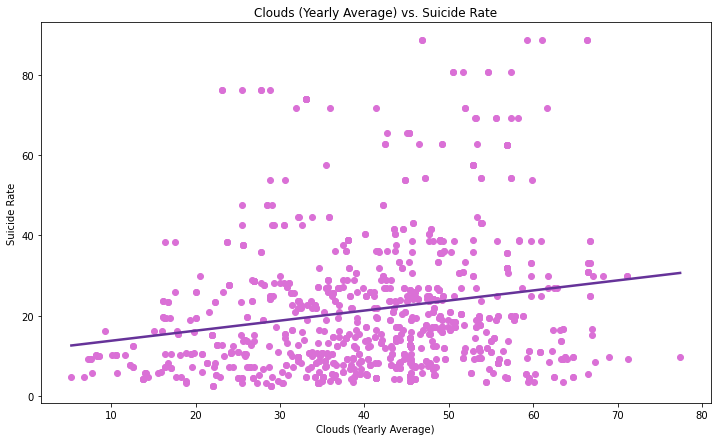

In [126]:
fig, ax = plt.subplots(figsize = (12, 7))   # initialize layout and set figure size
ax.scatter(df['Clou_Yearly_Av'], df['All'], color = "orchid")   # build scatterplot
b, a = np.polyfit(df['Clou_Yearly_Av'], df['All'], deg = 1)   # fit linear regression
# create sequence of numbers from x min to max
xseq = np.linspace(df['Clou_Yearly_Av'].min(), df['Clou_Yearly_Av'].max(), num = 100)
ax.plot(xseq, a + b * xseq, color = "rebeccapurple", lw = 2.5)   # plot line
plt.title('Clouds (Yearly Average) vs. Suicide Rate')      # sets the title
plt.xlabel('Clouds (Yearly Average)')         # sets the x-axis label
plt.ylabel('Suicide Rate')       # sets the y-axis label
plt.show()               # displays the plot

In [98]:
# find average suicide rate by gender
data = [['Female', df['Female'].mean()], ['Male', df['Male'].mean()]]
av_rates = pd.DataFrame(data, columns = ['Gender', 'Average'])

In [116]:
# function to add value labels
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white', fontsize = 14)

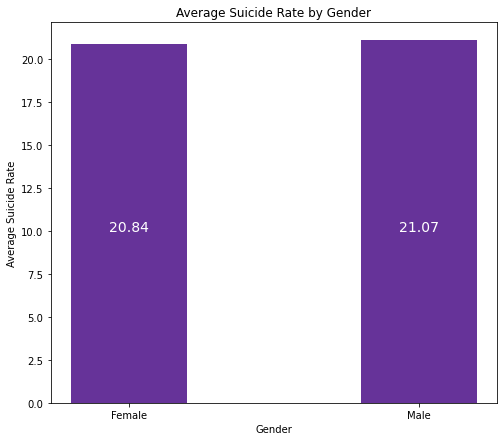

In [117]:
# set indices and width
ind = np.arange(2)
width = 0.4

fig = plt.figure(figsize = (8, 7))   # set size
 
# creating the bar plot and labels
plt.bar(ind, av_rates['Average'], color = 'rebeccapurple',
        width = width)
 
# calling the function to add value labels
addlabels(av_rates['Gender'], round(av_rates['Average'], 2))

# titles and labels
plt.xlabel("Gender")
plt.ylabel("Average Suicide Rate")
plt.title("Average Suicide Rate by Gender")
plt.xticks(ind,
          ('Female', 'Male'))
plt.show()

In [163]:
# find top 20 countries by suicide rate, dropping dups from multiple cities
no_dups = df.drop_duplicates(subset = ['Country'], keep = 'first')
top_20 = no_dups.nlargest(20, ['All'])

Text(0.5, 1.0, 'Top 20 Highest Suicide Rates by Location')

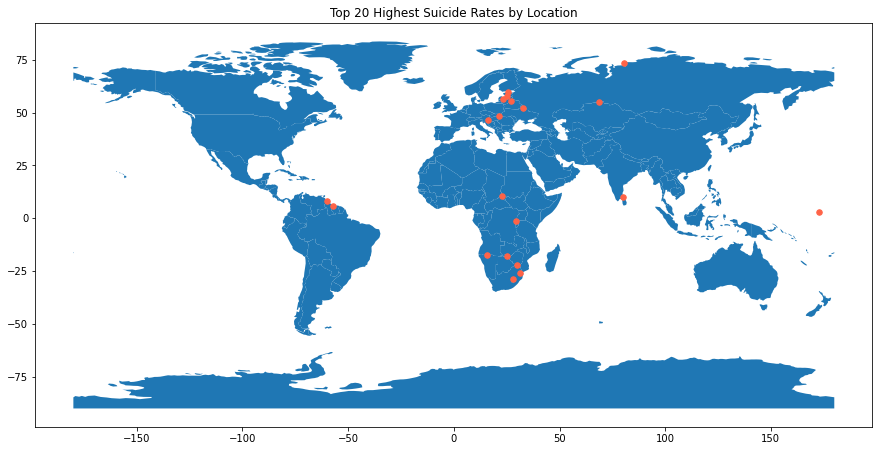

In [164]:
geometry_top = [Point(xy) for xy in zip(top_20['Longitude'], top_20['Latitude'])]   # list of locations
gdf_top = GeoDataFrame(top_20, geometry = geometry_top)     # build geo dataframe

# plot world map and then plot points on top
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_top.plot(ax = world.plot(figsize = (15, 18)), marker = 'o', color = 'tomato', markersize = 30)
plt.title('Top 20 Highest Suicide Rates by Location')   # set title

In [218]:
# find bottom 20 countries by suicide rate
bottom_20 = no_dups.nsmallest(20, ['All'])

Text(0.5, 1.0, 'Top 20 Lowest Suicide Rates by Location')

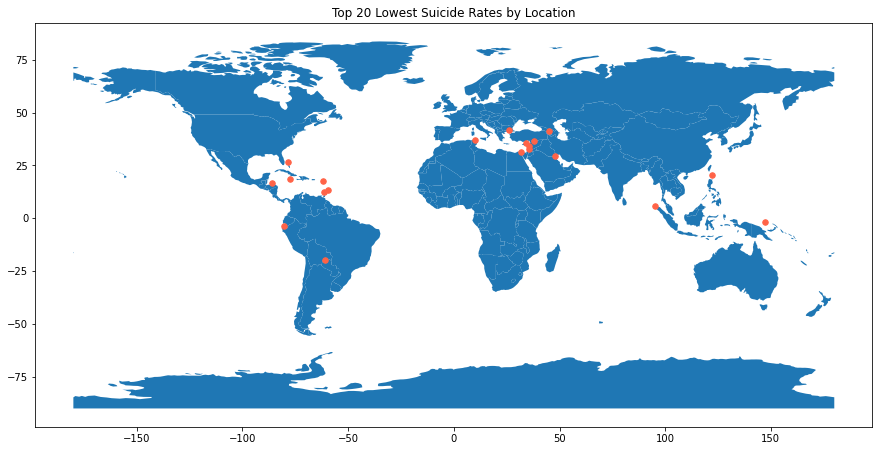

In [219]:
geometry_bottom = [Point(xy) for xy in zip(bottom_20['Longitude'], bottom_20['Latitude'])]   # list of locations
gdf_bottom = GeoDataFrame(bottom_20, geometry = geometry_bottom)     # build geo dataframe

# plot world map and then plot points on top
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_bottom.plot(ax = world.plot(figsize = (15, 18)), marker = 'o', color = 'tomato', markersize = 30)
plt.title('Top 20 Lowest Suicide Rates by Location')   # set title

In [180]:
# find highest and lowest suicide rate
extremes = pd.concat([df.nlargest(1, ['All']), df.nsmallest(1, ['All'])])

In [208]:
# pull average weather data and scale for plotting
high = extremes[['Temp_Yearly_Av', 'Pres_Yearly_Av', 'Humi_Yearly_Av', 'Wind_Yearly_Av', 'Prec_Yearly_Av',
         'Clou_Yearly_Av']].loc[extremes['Country'] == 'Russian Federation']
low = extremes[['Temp_Yearly_Av', 'Pres_Yearly_Av', 'Humi_Yearly_Av', 'Wind_Yearly_Av', 'Prec_Yearly_Av',
         'Clou_Yearly_Av']].loc[extremes['Country'] == 'Cyprus']

high['Pres_Yearly_Av'] = high['Pres_Yearly_Av']/100
low['Pres_Yearly_Av'] = low['Pres_Yearly_Av']/100

high['Prec_Yearly_Av'] = high['Prec_Yearly_Av']*10000
low['Prec_Yearly_Av'] = low['Prec_Yearly_Av']*10000

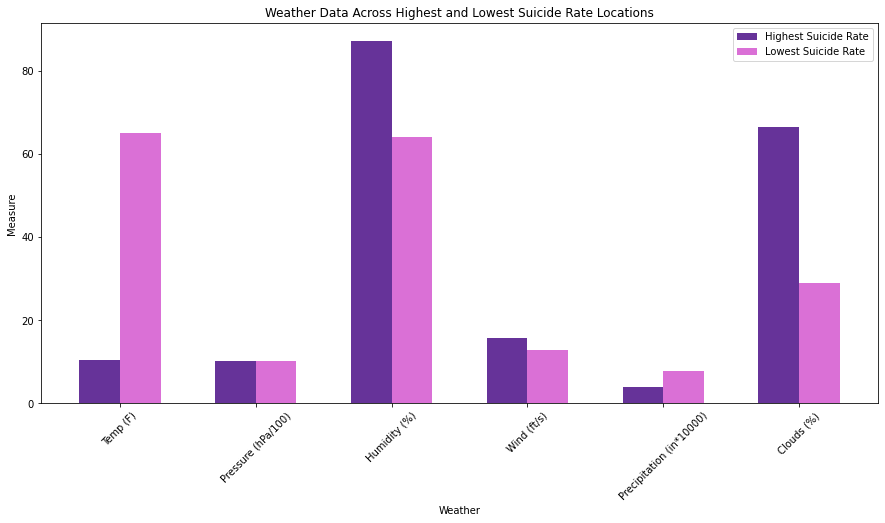

In [215]:
N = 6
# Specify the values of blue bars (height)
high_bar = high.values.tolist()[0]
# Specify the values of orange bars (height)
low_bar = low.values.tolist()[0]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize = (15, 7))

# Width of a bar 
width = 0.3 

# Plotting
plt.bar(ind, high_bar, width, label = 'Highest Suicide Rate', color = 'rebeccapurple')
plt.bar(ind + width, low_bar, width, label = 'Lowest Suicide Rate', color = 'orchid')

plt.xlabel('Weather')
plt.ylabel('Measure')
plt.title('Weather Data Across Highest and Lowest Suicide Rate Locations')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Temp (F)', 'Pressure (hPa/100)', 'Humidity (%)', 'Wind (ft/s)', 
                             'Precipitation (in*10000)', 'Clouds (%)'), rotation = 45)

# Finding the best position for legends and putting it
plt.legend(loc = 'best')
plt.show()